## Парсинг HTML. XPath

Выберите веб-сайт с табличными данными, который вас интересует.
Напишите код Python, использующий библиотеку requests для отправки HTTP GET-запроса на сайт и получения HTML-содержимого страницы.
Выполните парсинг содержимого HTML с помощью библиотеки lxml, чтобы извлечь данные из таблицы.
Сохраните извлеченные данные в CSV-файл с помощью модуля csv.

Ваш код должен включать следующее:
- Строку агента пользователя в заголовке HTTP-запроса, чтобы имитировать веб-браузер и избежать блокировки сервером.
- Выражения XPath для выбора элементов данных таблицы и извлечения их содержимого.
- Обработка ошибок для случаев, когда данные не имеют ожидаемого формата.
- Комментарии для объяснения цели и логики кода.

#### Импорт библиотек

In [130]:
import requests
import pandas as pd
import csv

from lxml import html
from fake_useragent import UserAgent
from pymongo import MongoClient


#### Config

In [15]:
# Определение целевого URL
url = "https://finance.yahoo.com/trending-tickers/"

# Создаём агента для имитация веб-браузера Мозила
ua = UserAgent() 
headers = {
    "User-Agent": ua.firefox, 
}


#### Парсинг суточной таблицы 30 трендовых акций с Yahoo Finance

In [74]:
# Отправка HTTP GET запроса на целевой URL с пользовательским заголовком User-Agent
try:
    response = requests.get(url, headers = headers)
    if response.status_code == 200:
        print("Успешный запрос API по URL: ", response.url)
    else:
        print("Запрос API отклонен с кодом состояния:", response.status_code)

except requests.exceptions.RequestException as e:
    print("Ошибка в осущественнии HTML запроса:", e)
    

Успешный запрос API по URL:  https://finance.yahoo.com/trending-tickers/


In [75]:
# Парсинг HTML-содержимого ответа всей страницы
try:
    tree = html.fromstring(response.content)
    print(tree)
except html.etree.ParserError as e:
    print("Ошибка в парсинге HTML содержимого:", e)
    

<Element html at 0x1a9086620c0>


In [76]:
# Выбираем из HTML-содержимого ответа всей страницы только нужную таблицу с трендовыми тикерами
try:
    table = tree.xpath('//*[@id="list-res-table"]/div[1]/table')
    
except IndexError as e:
    print("Ошибка доступа к результату:", e)

except Exception as e:
    print("Произошла непредвиденная ошибка:", e)


In [123]:
# Получаем названия столбцов таблицы
try:
    # Создаем пустой список для хранения названий столбцов
    column_names = []
    # Проходимся по всем столбцам от 1 до 8 
    # (столбцы 9-11 содержат в себе графики-спарклайны, а парсить и сохранять картинки в таблице я ещё не умею, поэтому их не брал)
    for i in range(1, 9):
        # Получаем название текущего столбца и добавляем его в список
        # [0] - нужен для того, чтобы из list, который получается при парсинге, извлекать сам string
        column_name = table[0].xpath(f"//thead/tr/th[{i}]/text()")[0]
        column_names.append(column_name)
    # Выводим все названия столбцов из списка
    print(column_names)
    # Создаем заготовку для таблицы с названиями столбцов
    df = pd.DataFrame(columns=column_names)

except IndexError as e:
    print("Ошибка доступа к результату:", e)
    
except Exception as e:
    print("Произошла непредвиденная ошибка:", e)


['Symbol', 'Name', 'Last Price', 'Market Time', 'Change', '% Change', 'Volume', 'Market Cap']


In [124]:
# Загружаем строки таблицы добавляя информацию отдельно по столбцам

# Создаем пустой список для хранения информации внутри 1 строки
info_in_line = []

# Цикл для прохода по каждой строке от 1 до 30
for i in range(1, 31):
    # Изменяем индекс строки в XPath выражении
    xpath_expression = f"//tbody/tr[{i}]"
    
    # Проходим от 1-ого до 8-ого столбца включительно и парсим данные
    # [0] - нужен для того, чтобы из list, который получается при парсинге, извлекать сам string
    # В таблице в одной строке в 1 колонке мне попалось отсутсвующее значение на сайте
    # Поэтому везде обработаем такой случай, чтобы код не падал, а в список значений строки добавлялось None
    
    column_1 = tree.xpath(f"{xpath_expression}/td[1]/a/text()")
    if column_1:
        info_in_line.append(column_1[0])
    else:
        info_in_line.append(None) 
    
    column_2 = tree.xpath(f"{xpath_expression}/td[2]/text()")
    if column_2:
        info_in_line.append(column_2[0])
    else:
        info_in_line.append(None)
    
    column_3 = tree.xpath(f"{xpath_expression}/td[3]/fin-streamer/text()")
    if column_3:
        info_in_line.append(column_3[0])
    else:
        info_in_line.append(None)
    
    column_4 = tree.xpath(f"{xpath_expression}/td[4]/fin-streamer/text()")
    if column_4:
        info_in_line.append(column_4[0])
    else:
        info_in_line.append(None)
    
    column_5 = tree.xpath(f"{xpath_expression}/td[5]/fin-streamer/span/text()")
    if column_5:
        info_in_line.append(column_5[0])
    else:
        info_in_line.append(None)
    
    column_6 = tree.xpath(f"{xpath_expression}/td[6]/fin-streamer/span/text()")
    if column_6:
        info_in_line.append(column_6[0])
    else:
        info_in_line.append(None)
    
    column_7 = tree.xpath(f"{xpath_expression}/td[7]/fin-streamer/text()")
    if column_7:
        info_in_line.append(column_7[0])
    else:
        info_in_line.append(None)
    
    column_8 = tree.xpath(f"{xpath_expression}/td[8]/fin-streamer/text()")
    if column_8:
        info_in_line.append(column_8[0])
    else:
        info_in_line.append(None)
    
    # Печатаем строку
    print(info_in_line)

    # Добавляем информацию из строки в датафрейм
    data = pd.DataFrame([info_in_line], columns=column_names)
    df = pd.concat([df, data])
    
    # Очищаем info_in_line для следующей строки
    info_in_line.clear()

# В полученном дата-фрейме все индексы строк равны 0, поэтому
# Создаем новый индекс, который начинается с 1 и имеет длину равную длине датафрейма
new_index = pd.RangeIndex(start=1, stop=len(df) + 1)
# Применяем новый индекс к датафрейму
df.set_index(new_index, inplace=True)


['FFIE', 'Faraday Future Intelligent Electric Inc.', '0.2852', '4:00PM EDT', '+0.2242', '+367.54%', '1.521B', '12.094M']
['SPWR', 'SunPower Corporation', '4.3900', '4:00PM EDT', '+1.6400', '+59.64%', '136.384M', '770.344M']
['PLUG', 'Plug Power Inc.', '3.4400', '4:00PM EDT', '+0.5500', '+19.03%', '200.984M', '2.554B']
['ORCL', 'Oracle Corporation', '120.87', '4:02PM EDT', '+4.50', '+3.87%', '17.594M', '332.212B']
['NU', 'Nu Holdings Ltd.', '11.55', '4:00PM EDT', '+0.17', '+1.49%', '24.426M', '54.236B']
['NESTE.HE', 'Neste Oyj', '19.26', '12:30PM EEST', '-2.92', '-13.17%', '3.428M', '14.796B']
['FCEL', 'FuelCell Energy, Inc.', '0.8840', '4:00PM EDT', '+0.1708', '+23.95%', '129.375M', '399.498M']
['ABN.AS', 'ABN AMRO Bank N.V.', '15.94', '11:15AM CEST', '-0.76', '-4.52%', '4.306M', '13.275B']
['BRBY.L', 'Burberry Group plc', '1,140.00', '10:15AM BST', '-48.50', '-4.08%', '1.203M', '4.088B']
['GME', 'GameStop Corp.', '48.75', '4:00PM EDT', '+18.30', '+60.10%', '196.754M', '14.927B']
['BA'

In [125]:
# Как видим только в поле Market Cap 1 значение имеет None
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1 to 30
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Symbol       30 non-null     object
 1   Name         30 non-null     object
 2   Last Price   30 non-null     object
 3   Market Time  30 non-null     object
 4   Change       30 non-null     object
 5   % Change     30 non-null     object
 6   Volume       30 non-null     object
 7   Market Cap   29 non-null     object
dtypes: object(8)
memory usage: 2.0+ KB


In [126]:
df

,Symbol,Name,Last Price,Market Time,Change,% Change,Volume,Market Cap
1,FFIE,Faraday Future Intelligent Electric Inc.,0.2852,4:00PM EDT,+0.2242,+367.54%,1.521B,12.094M
2,SPWR,SunPower Corporation,4.3900,4:00PM EDT,+1.6400,+59.64%,136.384M,770.344M
3,PLUG,Plug Power Inc.,3.4400,4:00PM EDT,+0.5500,+19.03%,200.984M,2.554B
4,ORCL,Oracle Corporation,120.87,4:02PM EDT,+4.50,+3.87%,17.594M,332.212B
5,NU,Nu Holdings Ltd.,11.55,4:00PM EDT,+0.17,+1.49%,24.426M,54.236B
6,NESTE.HE,Neste Oyj,19.26,12:30PM EEST,-2.92,-13.17%,3.428M,14.796B
7,FCEL,"FuelCell Energy, Inc.",0.8840,4:00PM EDT,+0.1708,+23.95%,129.375M,399.498M
8,ABN.AS,ABN AMRO Bank N.V.,15.94,11:15AM CEST,-0.76,-4.52%,4.306M,13.275B
9,BRBY.L,Burberry Group plc,"1,140.00",10:15AM BST,-48.50,-4.08%,1.203M,4.088B
10,GME,GameStop Corp.,48.75,4:00PM EDT,+18.30,+60.10%,196.754M,14.927B


Таблица на сайте для сравненения (данные парсил 15.05.2024 в 12-13 часов по МСК)

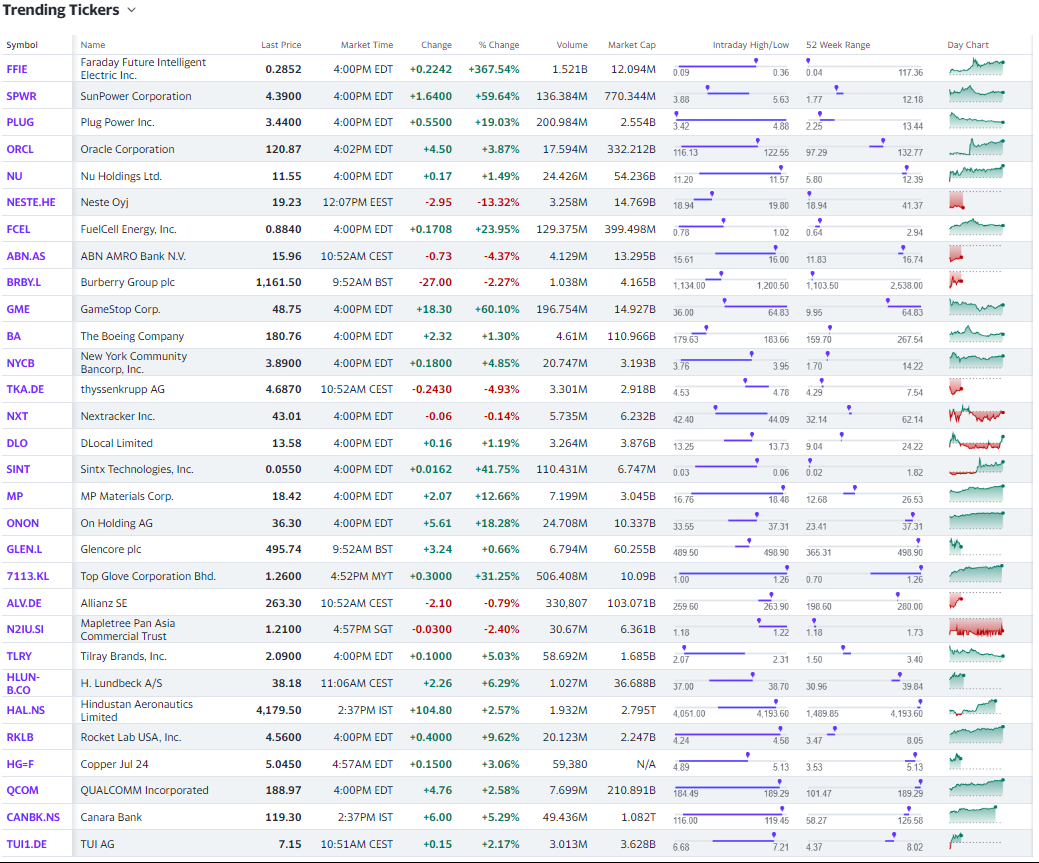

#### Сохранение данных в CSV

In [127]:
# Сохранение DataFrame в файл CSV
df.to_csv('trending_tickers_YahooFinance_15_05_2024.csv', index=False)

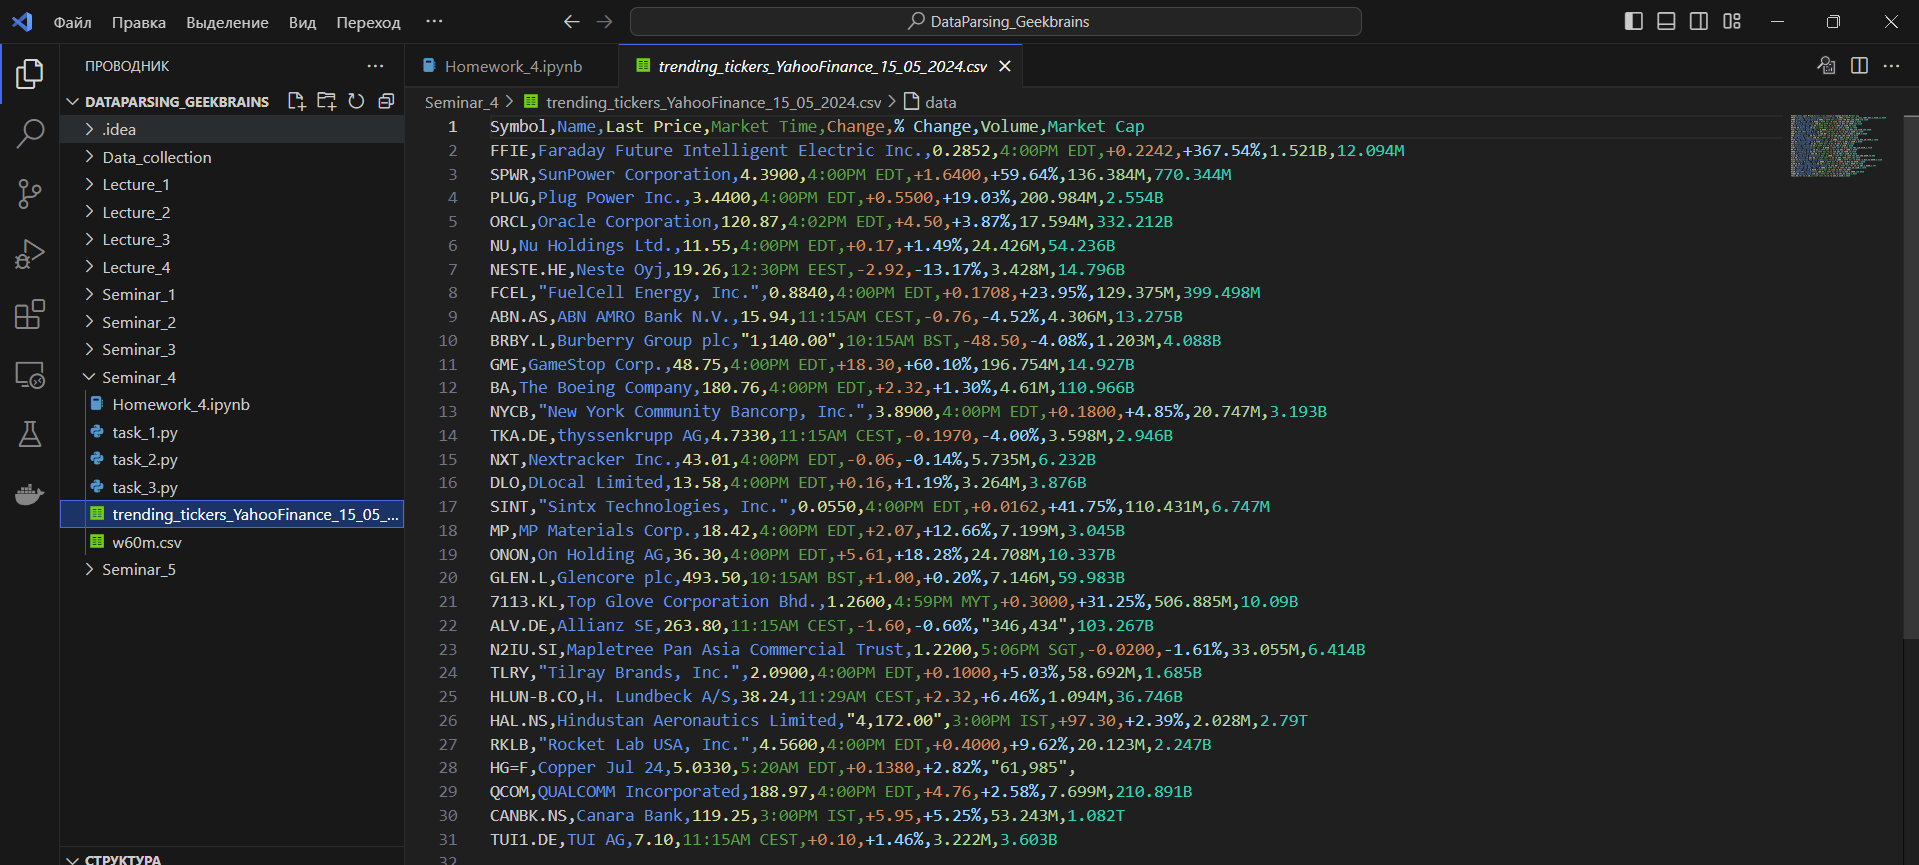

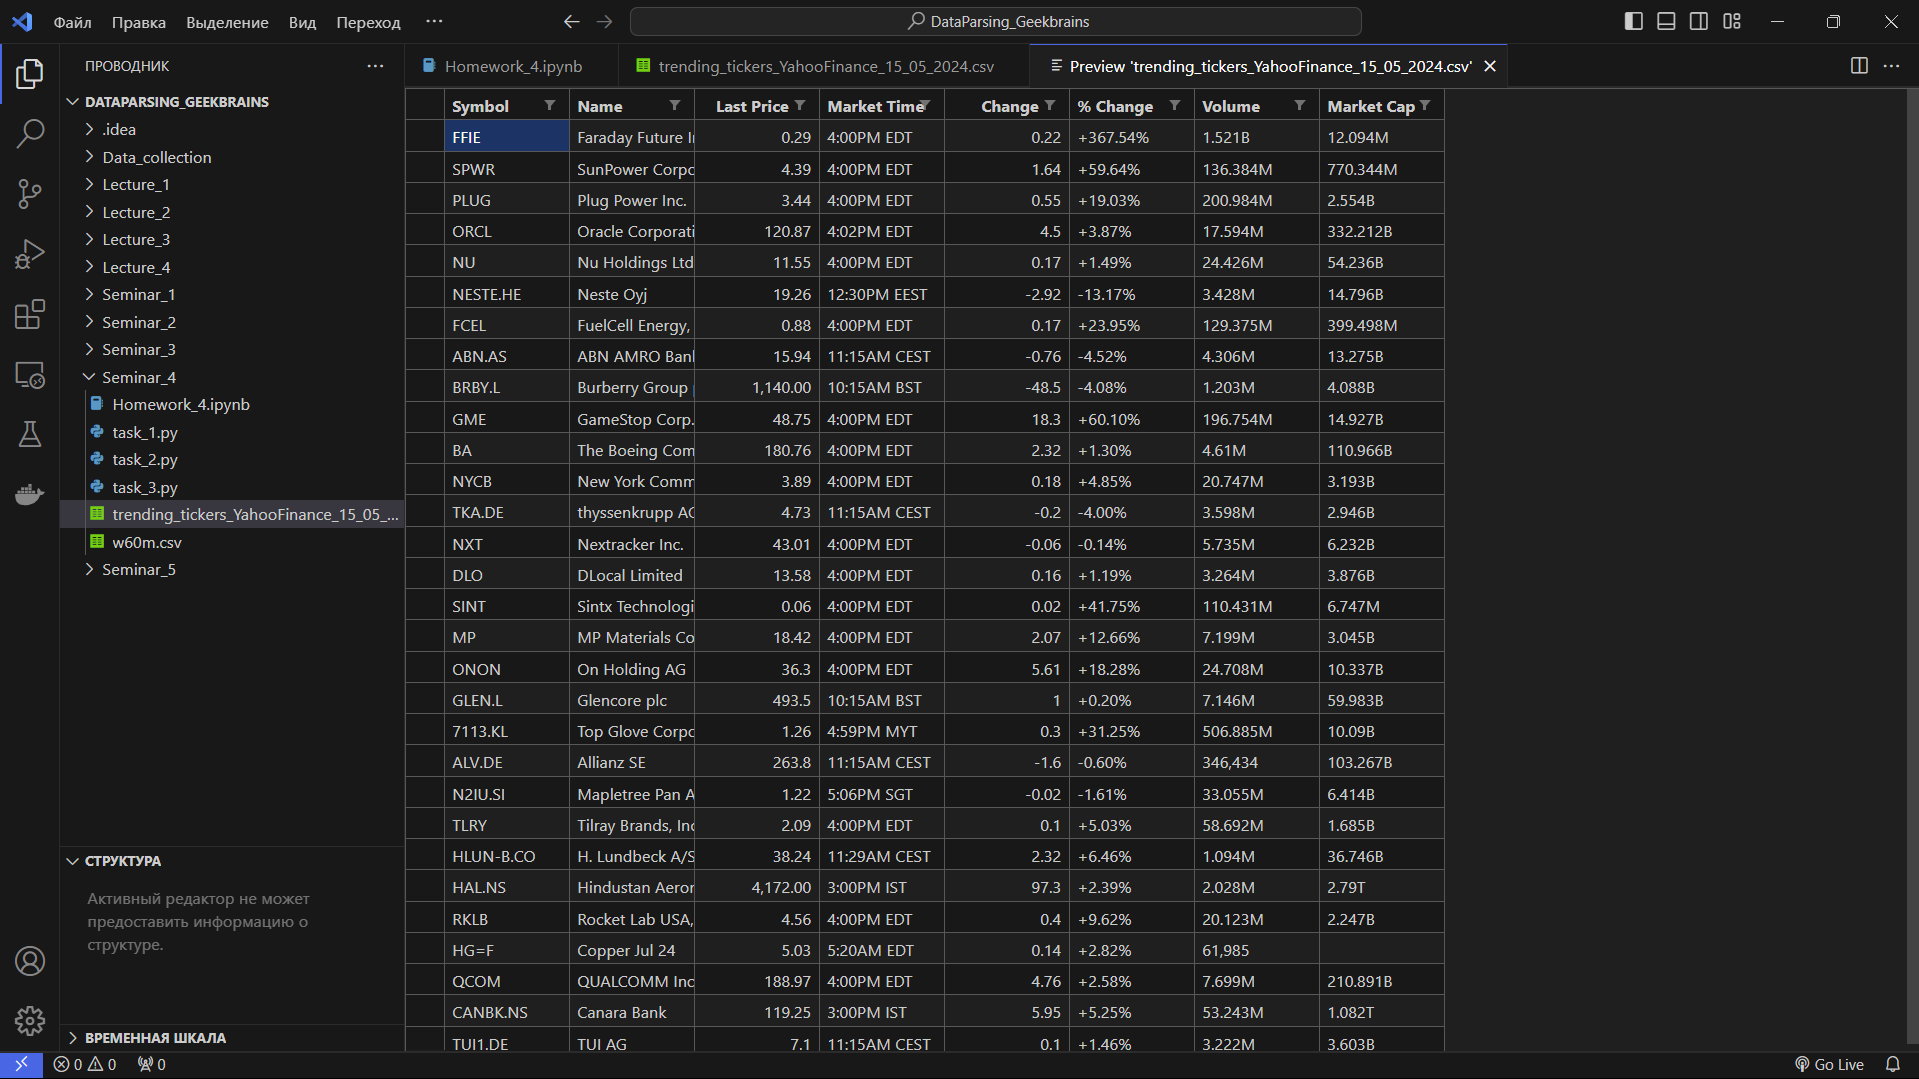

#### Сохранение данных в MongoDB

In [132]:
# Преобразование DataFrame в список словарей
documents = df.to_dict('records')

# Подключение к серверу MongoDB
client = MongoClient("mongodb://localhost:27017/")
# Выбор базы данных
YahooFinance_db = client['YahooFinance']
# Выбор коллекции
results_table = YahooFinance_db['trending_tickers']

# Вставка списка словарей в коллекцию MongoDB
results_table.insert_many(documents)


InsertManyResult([ObjectId('66448aa4714ea1ddd384f85f'), ObjectId('66448aa4714ea1ddd384f860'), ObjectId('66448aa4714ea1ddd384f861'), ObjectId('66448aa4714ea1ddd384f862'), ObjectId('66448aa4714ea1ddd384f863'), ObjectId('66448aa4714ea1ddd384f864'), ObjectId('66448aa4714ea1ddd384f865'), ObjectId('66448aa4714ea1ddd384f866'), ObjectId('66448aa4714ea1ddd384f867'), ObjectId('66448aa4714ea1ddd384f868'), ObjectId('66448aa4714ea1ddd384f869'), ObjectId('66448aa4714ea1ddd384f86a'), ObjectId('66448aa4714ea1ddd384f86b'), ObjectId('66448aa4714ea1ddd384f86c'), ObjectId('66448aa4714ea1ddd384f86d'), ObjectId('66448aa4714ea1ddd384f86e'), ObjectId('66448aa4714ea1ddd384f86f'), ObjectId('66448aa4714ea1ddd384f870'), ObjectId('66448aa4714ea1ddd384f871'), ObjectId('66448aa4714ea1ddd384f872'), ObjectId('66448aa4714ea1ddd384f873'), ObjectId('66448aa4714ea1ddd384f874'), ObjectId('66448aa4714ea1ddd384f875'), ObjectId('66448aa4714ea1ddd384f876'), ObjectId('66448aa4714ea1ddd384f877'), ObjectId('66448aa4714ea1ddd384f8

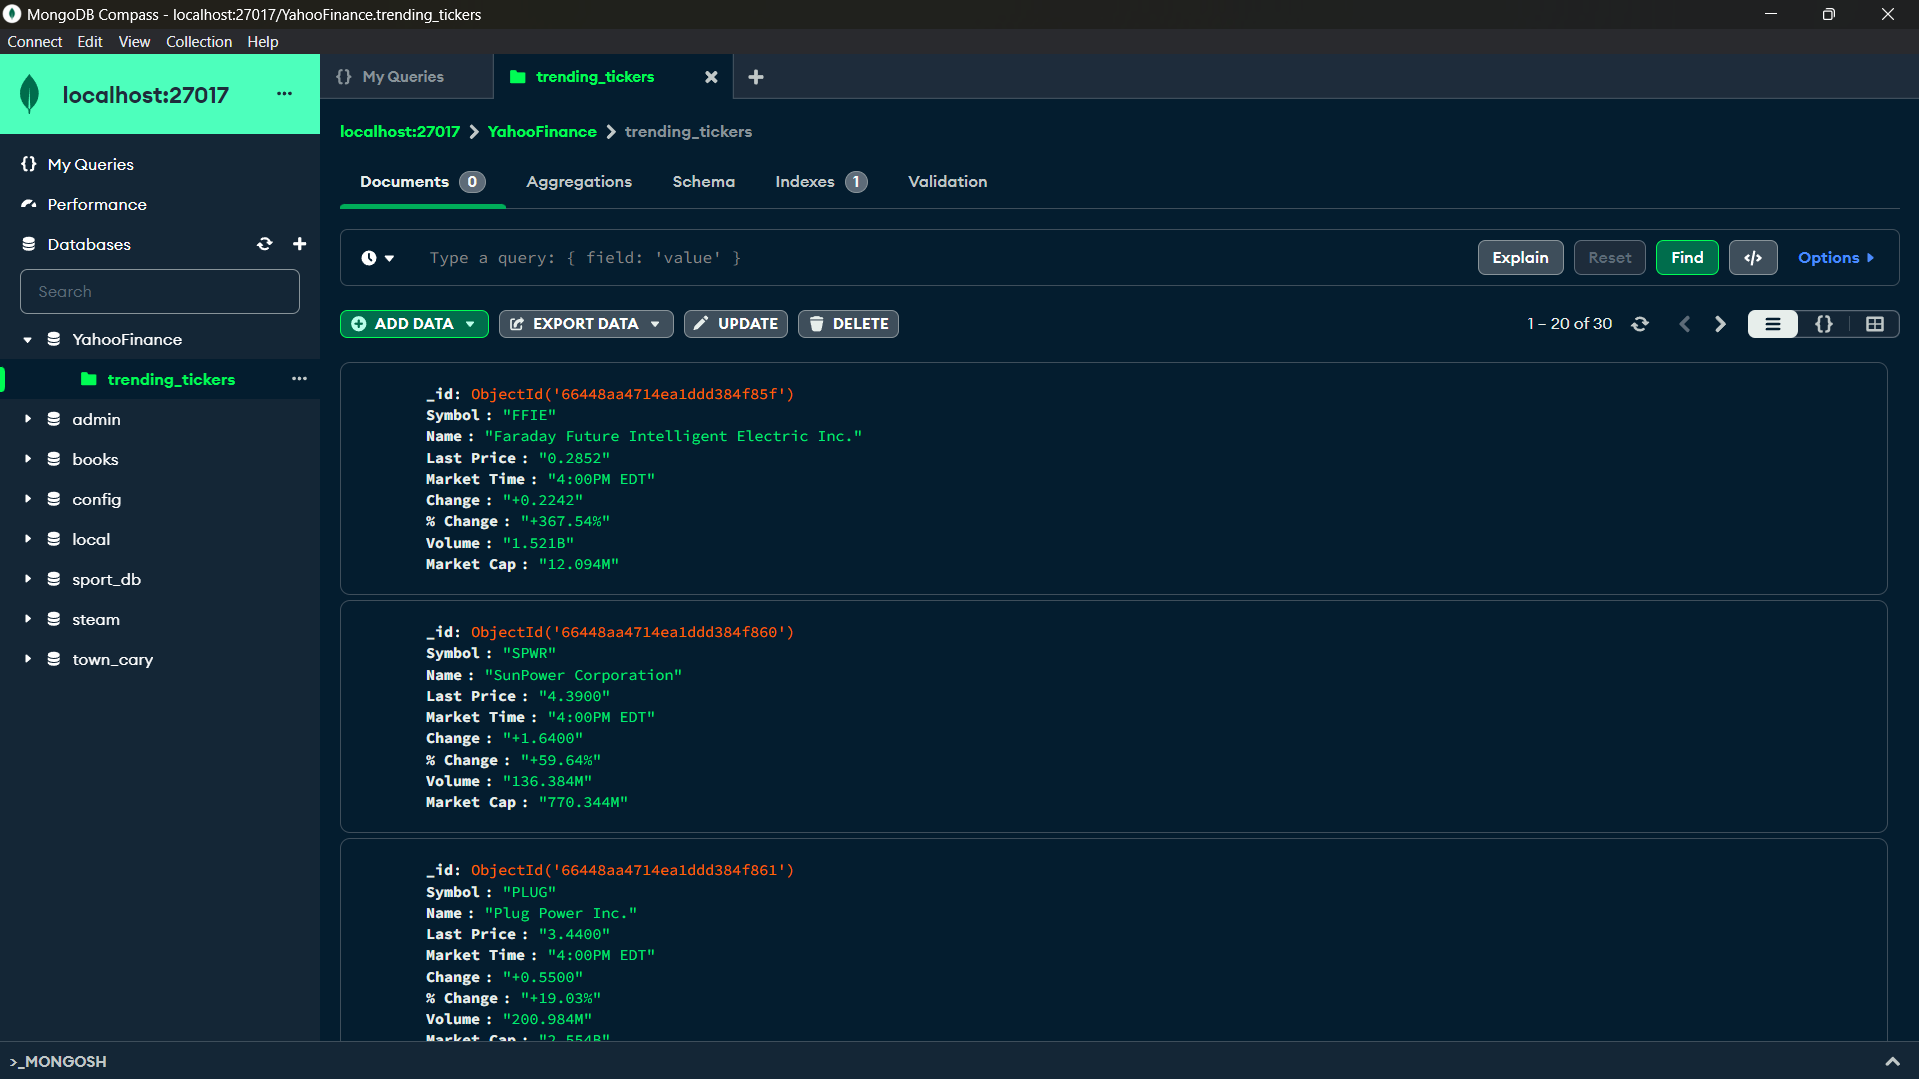

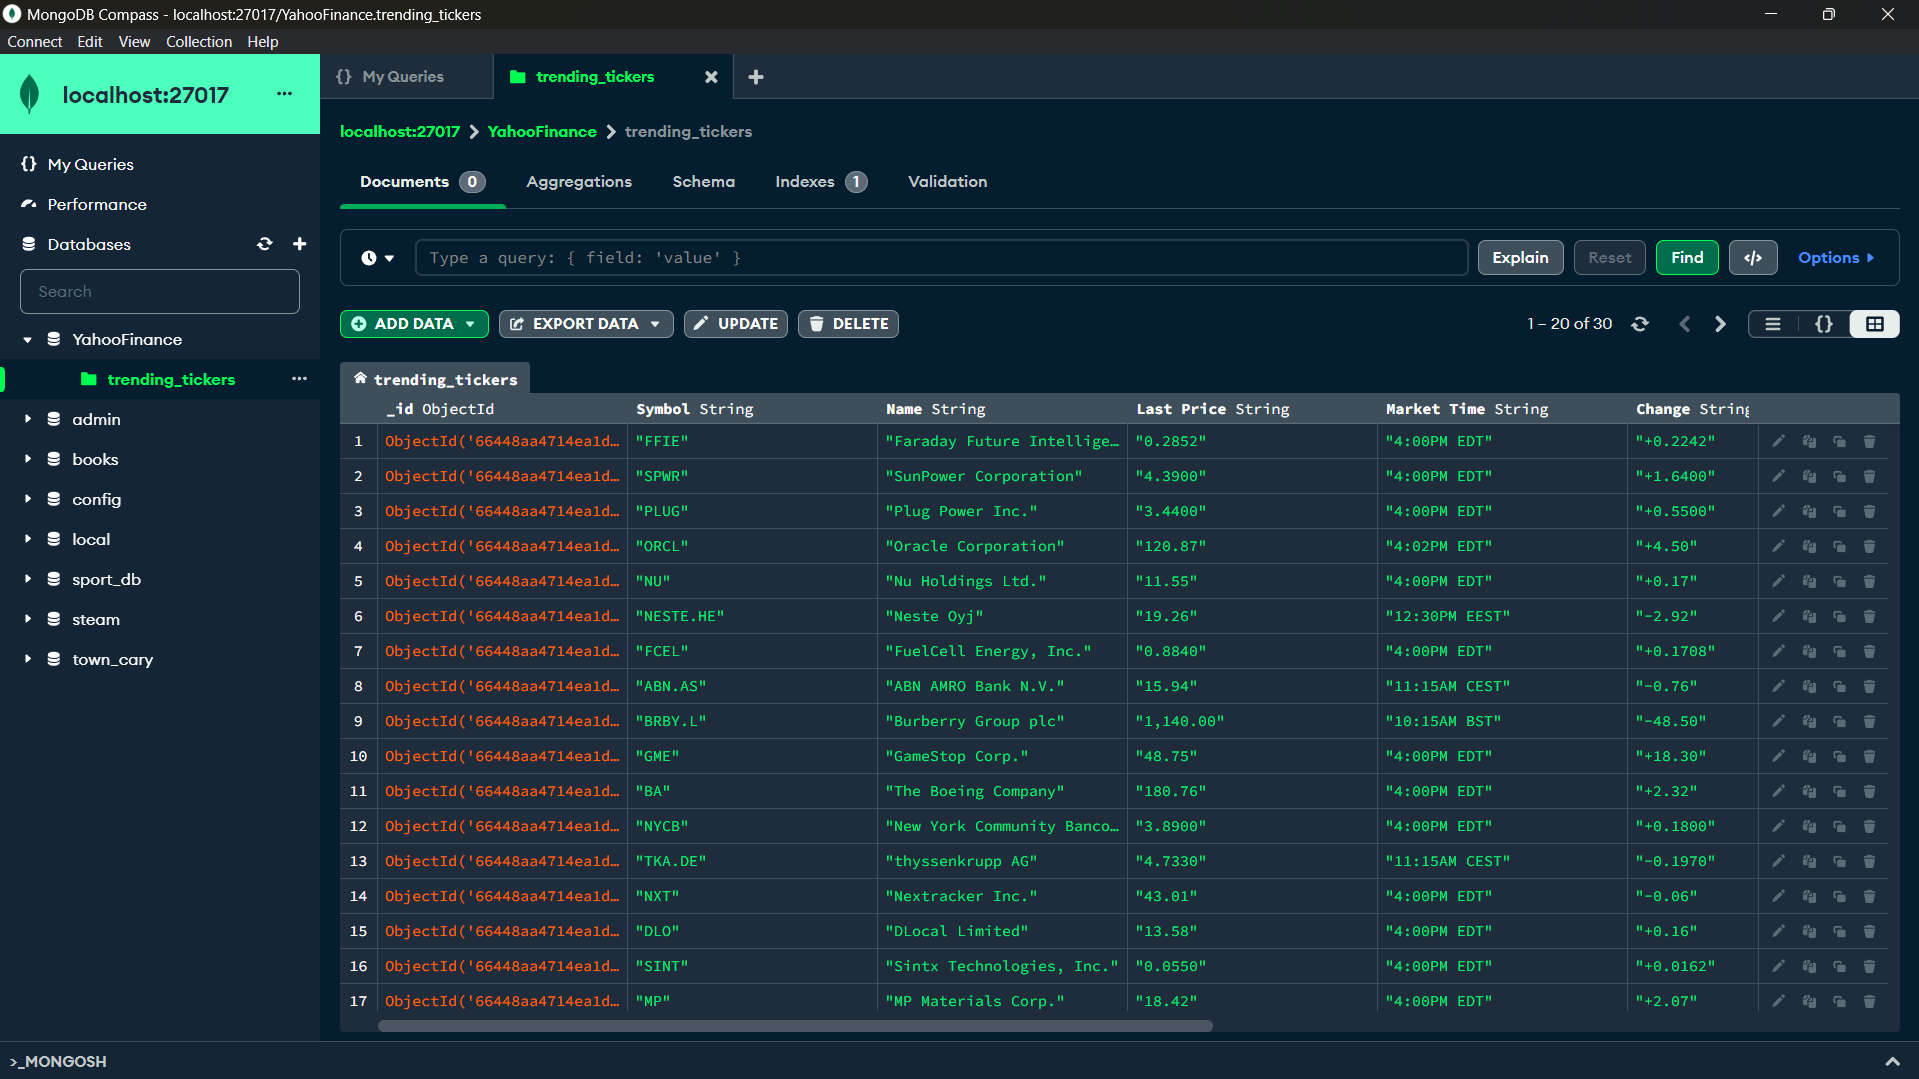